In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if "hh_combination_fw_path" not in os.environ:
    os.environ['hh_combination_fw_path'] = os.path.abspath("../../")
outdir_xsection = os.environ['hh_combination_fw_path']+'/output_HHH_20220415_noSgHparam/'
outdir_likelihood = os.environ['hh_combination_fw_path']+'/output_HHH_20220415/'

# plotdir = os.environ['hh_combination_fw_path']+'/output_HHH3/figures'
# os.makedirs(plotdir, exist_ok=True)

In [4]:
channels = ['bbtautau', 'bbyy', 'bbbb']
resonant_type = 'nonres'
combine_tag = 'A-bbtautau_bbyy-fullcorr'

In [5]:
def remove_list(data):
    for k, v in data.items():
        for p,v_ in v.items():
            data[k][p] = v_[0]
    return data


def get_xsection_data(study):
    data = {}
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir_xsection, study, channel, 'limits.json')
        data[channel] = json.load(open(limit_path))
    return data


In [6]:
channel_label_map = {
    'bbbb': r"$\mathrm{b\bar{b}b\bar{b}}$",
    'bbtautau': r"$\mathrm{b\bar{b}\tau^+\tau^-}$",
    'bbyy': r"$\mathrm{b\bar{b}\gamma\gamma}$",
    'combined': r"Combined",
}
channel_text = {
    'combined': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-} + b\bar{b}\gamma\gamma + b\bar{b}b\bar{b}$',
    'bbbb': r'$\mathrm{HH\rightarrow b\bar{b}b\bar{b}}$',
    'bbyy': r'$\mathrm{HH\rightarrow b\bar{b}\gamma\gamma}$',
    'bbtautau': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-}$',
}   


## 1. SM Limit Plot

### 1.1 Data Loading

In [49]:
# scale_factor = 1000/32.776
# sm_limit_df = {}
# channels = ['bbtautau', 'bbyy']
# data = get_limit_data(scenario, 'SM_out', True)
# data_dict = remove_list(data)
# sm_limit_df = pd.DataFrame(data_dict) * scale_factor

### 1.2 Plotting

In [50]:
# from quickstats.plots import UpperLimit1DPlot

In [51]:
# plotting_order = ['combined', 'bbyy', 'bbtautau']
# sm_limit_df = sm_limit_df[plotting_order]

In [52]:
# analysis_label_options = {'fontsize':30, 'energy': '13 TeV', 
#                                   'lumi': '139 fb$^{-1}$',
#                                   'extra_text': r'$\sigma_{ggF+VBF}^{SM}=32.78$ fb',
#                                   }
# styles = {
#             'axis':{
#                 'tick_bothsides': False,
#                 'major_length': 12,
#                 },
#             'legend':{
#                 'loc': 'upper right',
#                 },
#             'figure':{
#                 'figsize': (15,13),
#                 }
#         }
                     
# plotter = UpperLimit1DPlot(sm_limit_df, channel_label_map, line_below=["bbyy"],
#                            analysis_label_options=analysis_label_options, styles=styles)
# ax = plotter.draw(logx=True, xlabel=r"95% CL upper limit on signal strength", draw_observed=True, draw_stat=False)
# # ax.set_xlim([0, None])
# ax.set_xlim([1, 80])

# plt.savefig(plotdir+f"/plots/SM_limit.pdf", bbox_inches="tight")

## 2. Cross section Scan

In [66]:
import math
#Now using values from LHCWHGHHHXGGBGGGXXX
SCALE_GGF = 31.05/31.0358 #31.02/31.0358   #correct to xs at mH = 125.09 
SCALE_VBF = 1.726/(4.581-4.245+1.359) # 1.723/(4.581-4.245+1.359)

def xs_ggF(kl):
    #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
    return (70.3874-50.4111*kl+11.0595*kl**2)*SCALE_GGF #XS in fb

def xs_VBF(kl):
    #https://indico.cern.ch/event/995807/contributions/4184798/attachments/2175756/3683303/VBFXSec.pdf
    return (4.581-4.245*kl+1.359*kl**2)*SCALE_VBF

def xs_HH(kl, s=13):
    if s == 13:
        return xs_ggF(kl) + xs_VBF(kl)
    elif s == 14:
        return xs_ggF(kl)*1.18 + xs_VBF(kl) * 1.19

# When adding 2 independent Gaussians (e.g. ggF and VBF XS) we can simply add their means and add their sigmas in quadrature
def sigma_upper_ggF(kl):
    #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
    #add the std on ggF HH due to qcd scale, PDF, and mtop in quadrature
    #return xs_ggF(kl) * math.sqrt((max(72.0744-51.7362*kl+11.3712*kl**2, 70.9286-51.5708*kl+11.4497*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2 + 0.026**2)
    #new mtop uncertainty:
    return xs_ggF(kl) * math.sqrt((max(76.6075 - 56.4818*kl + 12.635*kl**2, 75.4617 - 56.3164*kl + 12.7135*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2)

def sigma_upper_VBF(kl):
    #from klambda = 1
    return xs_VBF(kl) * math.sqrt(0.0003**2 + 0.021**2)

def sigma_upper_HH(kl, s=13):
    error = math.sqrt(sigma_upper_ggF(kl)**2 + sigma_upper_VBF(kl)**2)
    if s == 14:
        error /= 2
    return error

def xs_upper_HH(kl, s=13):
    return xs_HH(kl, s) + sigma_upper_HH(kl, s)

def sigma_lower_ggF(kl):
    #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
    #add the std on ggF HH due to qcd scale, PDF, and mtop in quadrature
    #return xs_ggF(kl) * math.sqrt((min(66.0621-46.7458*kl+10.1673*kl**2, 66.7581-47.721*kl+10.4535*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2 + 0.026**2)
    #new mtop uncertainty:
    return xs_ggF(kl) * math.sqrt((min(57.6809 - 42.9905*kl + 9.58474*kl**2, 58.3769 - 43.9657*kl + 9.87094*kl**2) * SCALE_GGF / xs_ggF(kl) - 1)**2 + 0.03**2)

def sigma_lower_VBF(kl):
    return xs_VBF(kl) * math.sqrt(0.0004**2 + 0.021**2)

def sigma_lower_HH(kl, s):
    error = math.sqrt(sigma_lower_ggF(kl)**2 + sigma_lower_VBF(kl)**2)
    if s == 14:
        error /= 2
    return error
    
def xs_lower_HH(kl, s=13):
    return xs_HH(kl, s) - sigma_lower_HH(kl, s)


def get_intersections(lambdas, n_exp, lambdas_th, n_th):
    # get the intersection between expected and theory prediction
    
    # interpolate expected limit with same number of datapoints as used in theory prediction
    interpolated_limit = np.interp(lambdas_th, lambdas, n_exp) 

    #limitm1 = n*np.array(limit_bands[0]) - 1
    limitm1 = interpolated_limit - n_th 
    idx = np.argwhere(np.diff(np.sign(limitm1))).flatten() # determines what index intersection points are at 

    #linear interpolation to get exact intercepts: x = x1 + (x2-x1)/(y2-y1) * (y-y1)
    #y = 0 -> x = x1 - (x2-x1)/(y2-y1) * y1
    intersections = [lambdas_th[x] - (lambdas_th[x+1] - lambdas_th[x])/(limitm1[x+1] - limitm1[x]) * limitm1[x] for x in idx]
    return intersections

### 2.1 Load Parameterised workspace limits

In [85]:
kl_param_limit_df  = {}

kl_param_limit_df = {}
data = get_xsection_data('xsection_scan/')
for channel in data:
    df = pd.DataFrame(data[channel]).set_index(['klambda'])
    kl_param_limit_df[channel] = df

# kl_param_limit_df['bbyy']['obs'].to_numpy()
kl_param_limit_df.keys()


dict_keys(['bbtautau', 'bbyy', 'bbbb', 'combined'])

### 2.2 Plotting

In [65]:
from quickstats.plots import UpperLimit2DPlot

In [67]:
sE=13 # 13 TeV
klambda_values = kl_param_limit_df['bbbb'].index.astype(float).values
scale_factor = np.array([xs_HH(kl, s=sE) for kl in klambda_values])

klambda_theory_values = np.linspace(min(klambda_values), max(klambda_values), 1000) 
theory_xs_values = np.array([xs_HH(kl, s=sE) for kl in klambda_theory_values])
theory_xs_lower = np.array([xs_lower_HH(kl, s=sE) for kl in klambda_theory_values])
theory_xs_upper = np.array([xs_upper_HH(kl, s=sE) for kl in klambda_theory_values])

In [86]:
def plot_xsection_scan(channel):

    analysis_label_options = {
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    styles = {
        'legend':{
            'loc': (0.58, 0.63),
            'fontsize': 17
        }
    }

    plotter = UpperLimit2DPlot(kl_param_limit_df[channel], 
                               scale_factor=scale_factor, styles=styles,
                               analysis_label_options=analysis_label_options)
    plotter.add_curve(klambda_theory_values, theory_xs_values, theory_xs_lower, theory_xs_upper, 
                      label="Theory prediction")
    plotter.add_highlight(1, xs_HH(1, s=sE),
                          label="SM prediction")
    ax = plotter.draw(xlabel=r"$\mathrm{\kappa_{\lambda}}$", ylabel=r"$\sigma_{ggF+VBF}(HH) [fb]$",
                 draw_observed=True, log=True, ylim=[10, 1e5], xlim=[-6,11], observed_marker='')
    intersections = get_intersections(klambda_values, 
                                      scale_factor*kl_param_limit_df[channel]['0'],
                                      klambda_theory_values, theory_xs_values)

    intersections_obs = get_intersections(klambda_values, 
                                      scale_factor*kl_param_limit_df[channel]['obs'],
                                      klambda_theory_values, theory_xs_values)
    ax.annotate(r'Expected: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections[0], intersections[1]), 
                (0.05, 0.08), xycoords = 'axes fraction', fontsize = 18)
    ax.annotate(r'Observed: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections_obs[0], intersections_obs[1]), 
                (0.05, 0.15), xycoords = 'axes fraction', fontsize = 18)
    print(channel, 'obs', intersections_obs[0], intersections_obs[1])
    print(channel, 'exp', intersections[0], intersections[1])
    
    # Add individual curves on top
    if channel == 'combined':
        pass

    save_foler = outdir_xsection+"/figures/xsection_scan/"
    os.makedirs(save_foler, exist_ok=True)
    plt.savefig(save_foler+f"kl_limit_parameterised_ws_{channel}.pdf", bbox_inches="tight")
    print("save to", save_foler)


combined obs -0.5703622368485822 6.624711507552841
combined exp -0.9569862927228217 7.078832276303755
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/output_HHH3/figures/xsection_scan/


<Figure size 432x288 with 0 Axes>

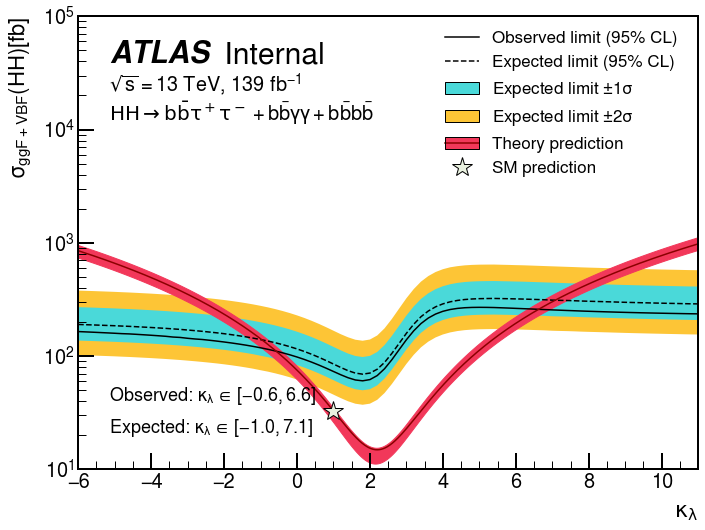

In [87]:
# plot_xsection_scan('bbbb')
# plot_xsection_scan('bbtautau')
# plot_xsection_scan('bbyy')
plot_xsection_scan('combined')


## 3. Likelihood Scan

In [32]:
def get_likelihood_data(obs, study):
    data = {}
    for channel in channels:
        limit_path = os.path.join(outdir_likelihood, 'likelihood_scan', obs, channel, study, 'klambda.json' if '1D' in study else 'klambda_kt.json')
        data[channel] = json.load(open(limit_path))
    return data

def data_loading_lh(obs, study):
    likelihood_df  = {}
    data = get_likelihood_data(obs, study)
    for channel in data:
        df = pd.DataFrame(data[channel]).dropna()
        likelihood_df[channel] = df
    return likelihood_df

In [33]:
from quickstats.plots import Likelihood1DPlot
from quickstats.plots.color_schemes import QUICKSTATS_PALETTES
color_pallete = QUICKSTATS_PALETTES['default']
from scipy.interpolate import interp1d
def get_interval(df, level):
    xvalues = df['mu'].to_numpy()
    yvalues = df['qmu'].to_numpy()
    func_theory = interp1d(xvalues, yvalues)
    x_new = np.arange(min(xvalues), max(xvalues), 0.01)
    y_new = func_theory(x_new)
    
    asign = np.sign(y_new-level)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    return x_new[signchange==1]

In [34]:
channels = ['bbyy']#, 'bbtautau', 'bbbb']

studies = ['1D_kt_nominal'] #, '1D_kt_profiled', '2D_kl_kt']
obs = 'asimov'
likelihood_df = {}
for study in studies:
    likelihood_df[study] = data_loading_lh(obs, study)
    print(likelihood_df[study].keys())


dict_keys(['bbyy'])


### 3.1 1D nominal

In [35]:
styles_map = {
    'bbbb': {"color": color_pallete[3], "linestyle": "--"},
    'bbyy': {"color": color_pallete[1], "marker": "s"},
    'bbtautau': {"color": color_pallete[2], "marker": "v"},
    'combined': {"color": color_pallete[0], "marker": "o"},
}

styles = {
    '1D_kt_nominal': {
        'legend': {
            'loc': (0.19, 0.42)
        },
    },
    '1D_kt_profiled': {
        'legend': {
            'loc': (0.17, 0.40)
        },
    },
    '2D_kl_kt': {
        'legend': {
            'loc': (0.17, 0.42)
        },
    },
}
anno_op = {
    '1D_kt_nominal': {
        'x': 0.50,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    '1D_kt_profiled': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    '2D_kl_kt': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
}

analysis_label_options_new = {
    '1D_kt_nominal': {
        'loc': (0.19, 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'139 fb$^{-1}$',
        'extra_text': channel_text['combined'] + r"//Observed data ($\kappa_{t} = 1$)",
    },
    '1D_kt_profiled': {
        'loc': (0.17, 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'139 fb$^{-1}$',
        'extra_text': channel_text['combined'] + r"//Observed data ($\kappa_{t}$ profied)",
    },
    '2D_kl_kt': {
        'loc': (0.17, 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'139 fb$^{-1}$',
        'extra_text': channel_text['combined'] + r'//Observed data',
    },
}

In [38]:
def plot_kl(study, xmin = -5, xmax = 12, ymax = 12 ):
    plotter = Likelihood1DPlot(likelihood_df[study], label_map=channel_label_map, styles_map=styles_map,
                            styles=styles[study], analysis_label_options=analysis_label_options_new[study])
    ax = plotter.draw(xlabel=r"$\mathrm{\kappa_{\lambda}}$", ymax=ymax, xmin=xmin, xmax=xmax, draw_sigma_line=True)

    if 'combined' in likelihood_df[study]:
        print(likelihood_df[study]['combined'][likelihood_df[study]['combined']['qmu'] <= 0])
        intersections_1 = get_interval(likelihood_df[study]['combined'], 1).tolist()
        intersections_2 = get_interval(likelihood_df[study]['combined'], 4).tolist()

        ax.annotate(r'Combined:', 
                    (anno_op[study]['x'], anno_op[study]['y']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$1\sigma$: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections_1[0], intersections_1[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$2\sigma$: $\kappa_\lambda \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - 2 * anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])

    savefolder = outdir_likelihood + '/figures/likelihood_scan'
    os.makedirs(savefolder, exist_ok=True)
    plt.savefig(savefolder+f"/likelihood_scan_{study}.pdf", bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

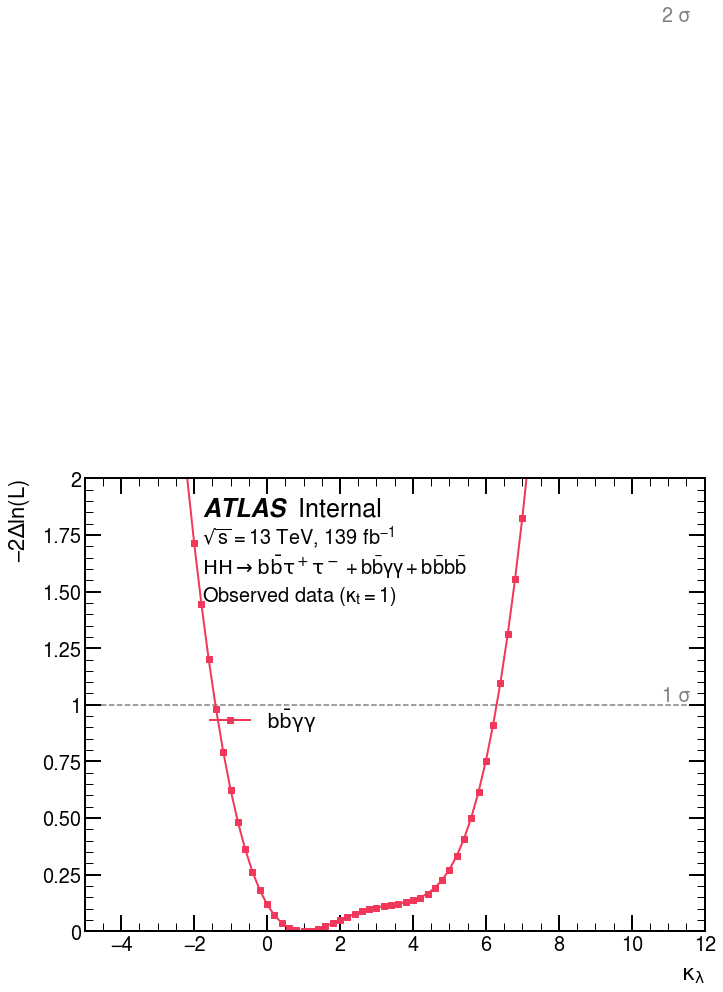

In [39]:
for study in studies:
    if '2D' in study: continue

    plot_kl(study)

              nll       qmu   mu
91  756982.508273 -0.027563  3.0
92  756982.510726 -0.022658  3.2


<Figure size 432x288 with 0 Axes>

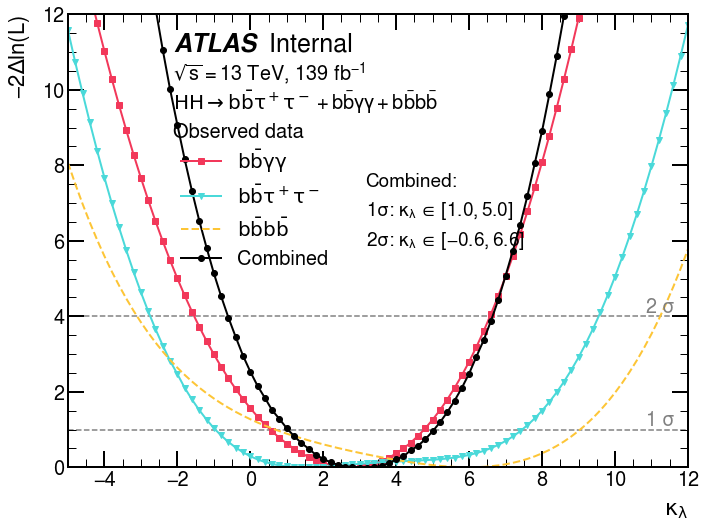

In [55]:
plot_kl(klhy = 2)

### 3b kappa t

In [37]:
styles_map = {
    'bbbb': {"color": color_pallete[3], "linestyle": "--"},
    'bbyy': {"color": color_pallete[1], "marker": "s"},
    'bbtautau': {"color": color_pallete[2], "marker": "v"},
    'combined': {"color": color_pallete[0], "marker": "o"},
}

detail_x = {
    1: 0.28,
    2: 0.29,
}

styles = {
    1: {
        'legend': {
            'loc': (detail_x[1], 0.42)
        },
    },
    2: {
        'legend': {
            'loc': (detail_x[2], 0.42)
        },
    },
}
anno_op = {
    1: {
        'x': detail_x[1] + 0.3,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    2: {
        'x': detail_x[2] + 0.3,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
}

analysis_label_options_new = {
    1: {
        'loc': (detail_x[1], 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'139 fb$^{-1}$',
        'extra_text': channel_text['combined'] + r"//Asimov data $(\kappa_{\lambda} = 1)$",
    },
    2: {
        'loc': (detail_x[2], 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'139 fb$^{-1}$',
        'extra_text': channel_text['combined'] + r'//Observed data',
    },
}

In [11]:
channels = ['bbyy', 'bbtautau', 'bbbb']

likelihood_df = {}
# likelihood_df[0]= data_loading_lh('kl_validation_3ch', 0, combined=True)
likelihood_df[1] = data_loading_lh('kt_3ch', 1, combined=True, poi='kt')
likelihood_df[2] = data_loading_lh('kt_3ch', 2, combined=True, poi='kt')

# print(likelihood_df[0].keys())
print(likelihood_df[1].keys())
print(likelihood_df[2].keys())

dict_keys(['bbyy', 'bbtautau', 'bbbb', 'combined'])
dict_keys(['bbyy', 'bbtautau', 'bbbb', 'combined'])


In [33]:
def plot_kt(klhy = 1, channel = 'combined' ):
    plotter = Likelihood1DPlot(likelihood_df[klhy], label_map=channel_label_map, styles_map=styles_map,
                            styles=styles[klhy], analysis_label_options=analysis_label_options_new[klhy])
    ax = plotter.draw(xlabel=r"$\mathrm{\kappa_{t}}$", ymax=12, xmin=-2, xmax=2, draw_sigma_line=True)

    print(likelihood_df[klhy]['combined'][likelihood_df[klhy]['combined']['qmu'] <= 0])

    intersections_1 = get_interval(likelihood_df[klhy]['combined'], 1).tolist()
    intersections_2 = get_interval(likelihood_df[klhy]['combined'], 4).tolist()

    ax.annotate(r'Combined:', 
                (anno_op[klhy]['x'], anno_op[klhy]['y']), xycoords = 'axes fraction', fontsize = anno_op[klhy]['font_size'])
    ax.annotate(r'$1\sigma$: $\kappa_t \in [%.1f, %.1f]$' %(intersections_1[0], intersections_1[1]), 
                (anno_op[klhy]['x'], anno_op[klhy]['y'] - anno_op[klhy]['dy']), xycoords = 'axes fraction', fontsize = anno_op[klhy]['font_size'])
    ax.annotate(r'$2\sigma$: $\kappa_t \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
                (anno_op[klhy]['x'], anno_op[klhy]['y'] - 2 * anno_op[klhy]['dy']), xycoords = 'axes fraction', fontsize = anno_op[klhy]['font_size'])

    plt.savefig(plotdir+f"plots/likelihood_scan_kt_{klhy}_{channel}.pdf", bbox_inches="tight")
    

              nll  qmu   mu
31  727562.464231  0.0  1.0


<Figure size 432x288 with 0 Axes>

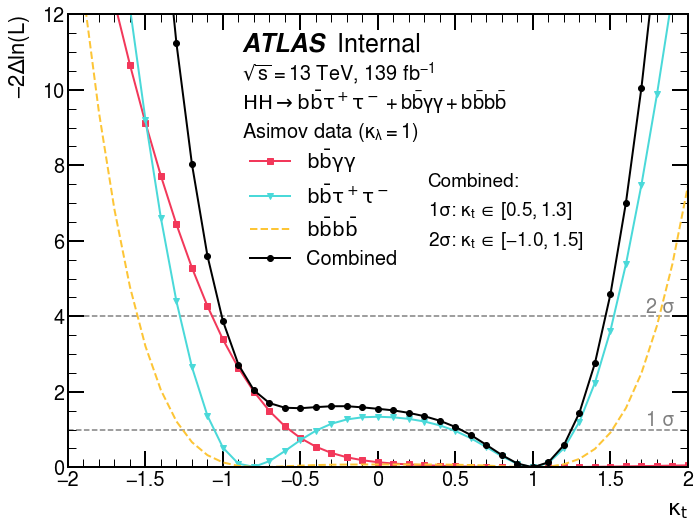

In [35]:
plot_kt(klhy = 1)

Empty DataFrame
Columns: [nll, qmu, mu]
Index: []


<Figure size 432x288 with 0 Axes>

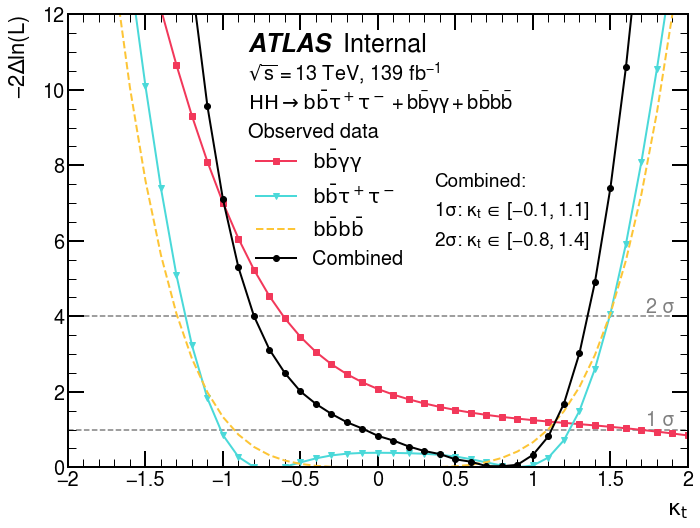

In [38]:
plot_kt(klhy = 2)
